# The numpy.random Package

## Overview
Numpy.random is the sub-package of the numpy numerical computing Python package that deals with random (really pseudo-random [1]) number generation. Two classes `numpy.random.BitGenerator` and `numpy.random.Generator` are used together to generate pseudo random numbers. `Generator` can be instantiated in two ways;
1. by calling the constructor with the name of the desired BitGenerator algorithm, or;
1. by calling `numpy.random.default_rng()`, a convenience function which will return a `Generator` object instantiated with the default `BitGenerator`, currently PCG64 [1]  

The second method is the one recommended by the numpy documentation [1].

`numpy.random.BitGenerator` is the base class for all of the bit generators provided by the numpy package. It is an abstract class and so cannot be instantiated. Several BitGenerators are provided by numpy. Of particular interest are `PCG64`, the default `numpy.random` BitGenerator, and `MT19937`, also known as the *Mersenne Twister*[1], the Python language's standard BitGenerator[1]. The `BitGenerator` base class provides the attribute `seed` which is used to intialise whichever BitGenerator is instantiated so that the sequence of numbers it produces are deterministic and therefore reproduceable[8]. If no seed is passed one isgenerated from system entropy[9]. Where a seed is passed the `numpy.random.SeedSequence` class is used to derive the `BitGenerator`'s initial state [9].

In [18]:
# Imports
import numpy as np
# Used to initilaise current default BitGenerator
from numpy.random import default_rng
# Used to initialise any available BitGenerator
from numpy.random import Generator
# Two of numpy's BitGenerators
from numpy.random import PCG64, MT19937
# For plotting distributions, etc
import matplotlib.pyplot as plt

Below is a demonstration of `numpy.random.default_rng()`. 

In [19]:
# Initialise Generator with default 
# BitGenerator (PCG64) with seed 0
rng = default_rng(0)
print(f"Type returned by default_rng():\t\t{type(rng)}")
print(f"BitGenerator returned by default_rng():\t{rng.bit_generator}")

Type returned by default_rng():		<class 'numpy.random._generator.Generator'>
BitGenerator returned by default_rng():	<numpy.random._pcg64.PCG64 object at 0x7fddac21a0f0>


In [20]:
print("State of BitGenerator returned by default_rng(0):")
display(rng.bit_generator.state)

State of BitGenerator returned by default_rng(0):


{'bit_generator': 'PCG64',
 'state': {'state': 35399562948360463058890781895381311971,
  'inc': 87136372517582989555478159403783844777},
 'has_uint32': 0,
 'uinteger': 0}

In [21]:
# Generate 10 integers using Generator 
print(rng.integers(0,10, 10))
print(rng.bit_generator.state['state'])
# Generate another 10 integers
print(rng.integers(0,10, 10))
print(rng.bit_generator.state['state'])
print(rng.bit_generator.state['state'])

[8 6 5 2 3 0 0 0 1 8]
{'state': 133411349017971402732463711865589153492, 'inc': 87136372517582989555478159403783844777}
[6 9 5 6 9 7 6 5 5 9]
{'state': 171367656177275072274709569355545309177, 'inc': 87136372517582989555478159403783844777}
{'state': 171367656177275072274709569355545309177, 'inc': 87136372517582989555478159403783844777}


In [22]:
generator = Generator(PCG64(0))
print(generator.integers(0,10, 10))
print(generator.integers(0,10, 10))

[8 6 5 2 3 0 0 0 1 8]
[6 9 5 6 9 7 6 5 5 9]


In [23]:
pcg64 = PCG64(0)
print(pcg64.random_raw(10))
pcg64.state['state']

[11749869230777074271  4976686463289251617   755828109848996024
   304881062738325533 15002187965291974971 16837368535893154894
 11190454901533422207 13456836363123071557 10028111089635196863
 17249041691996241901]


{'state': 171367656177275072274709569355545309177,
 'inc': 87136372517582989555478159403783844777}

In [24]:
ss = np.random.SeedSequence()
print(ss.entropy)
ss2 = np.random.SeedSequence()
print(ss2.entropy)
ss.generate_state(10, 'uint64')

324480140409182296392654660859815787002
24743512970217247963138398328371326953


array([ 5710443400098873391,  3709837163510141559, 16053387027962705221,
        2841913982300878565,  5844099058497373023, 16839166770220837364,
        3963306467416645233, 17547354837411721871, 14881069919737232449,
        1283817351080908622], dtype=uint64)

## Creating simple random data with `numpy.random`
The `Generator` class provides four methods for generating collections of random numbers when the probability distributions of those numbers is not important: `integers()`, which generates integers, `random()`, which generates floats,`choice()` which returns random selections from a passed list, and `bytes()`, which generates a string of random bytes.

### `numpy.random.Generator.integers()`
Signature : `integers(low, high=None, size=None, dtype=np.int64, endpoint=False)`

This method generates random integers in the range (`low`, `high`). It will return a single integer if called with one or two arguments. If called with one numeric argument, $a$ it will return an unsigned integer, $n$ such that $n<a$, or, if the boolean argument `endpoint` is `True`, $n{\le}a$. If called with two numeric arguments, the range 

[84 28 58 ... 76 67 91]


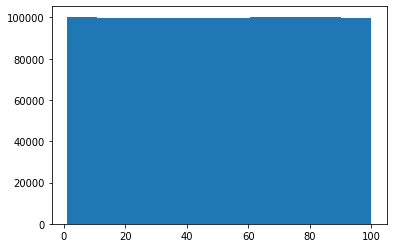

In [64]:
rng = default_rng(997878)
ints = rng.integers(1, 101, 1000000)
print(ints)
plt.hist(ints)
plt.show()

In [68]:
rng.choice(1, 100, p=[0.25, 0.5, 0.25])

ValueError: a and p must have same size

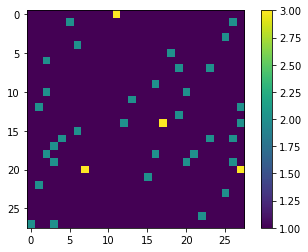

In [40]:
import matplotlib.pyplot as plt
plt.imshow(mat)
plt.colorbar()

### `random`

### `choice`

### `bytes`

## Permutations

### `shuffle`

### `permute`

### `permuted`

## Some distribution functions

### 1. The Gumbel Distribution
#### `random.Generator.gumbel`
$$ p(x)=\frac{e^{-(x-\mu)/\beta}}{\beta}e^{-e^{-(x-\mu)/\beta}} $$



### 2.

### 3.

### 4.

### 5.

## Seeds

PCG64 Details
Comparison between PCG64 and Mersenne Twister with focus on on performance (i.e. how does PCG64 outperform MT19937?)

Setting seeds in numpy rng

***
## References

## RNG General
[1] https://www.pcg-random.org/rng-basics.html

### PCG
[2] Lemire, D., 2017, On Melissa O’Neill’s PCG random number generator, https://lemire.me/blog/2017/08/15/on-melissa-oneills-pcg-random-number-generator/

[3] O' Neill, M., 2014, PCG, A Family of Better Random Number Generators, https://www.pcg-random.org/

[4] O' Neill, M., 2014, PCG: A Family of Simple Fast Space-Efficient Statistically Good Algorithms for Random Number Generation, https://www.pcg-random.org/pdf/hmc-cs-2014-0905.

### RNG Seeding
[5] Woodcock, H., 2021, Stop using numpy.random.seed(), https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f

### Numpy Docs
[7] https://numpy.org/doc/stable/reference/random/index.html

[8] https://numpy.org/doc/stable/reference/random/bit_generators/index.html

[9] https://numpy.org/doc/stable/reference/random/bit_generators/generated/numpy.random.BitGenerator.html